
ClusC of single:
[(7, array([1, 2, 3, 5, 7, 8, 9]), 0.4),
 (4, array([2, 3, 5, 7]), 0.35),
 (3, array([0, 4, 6]), 0.45),
 (2, array([4, 6]), 0.4),
 (2, array([8, 9]), 0.35),
 (2, array([2, 7]), 0.3)]

ClusR of single:
[(18,
  array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       19]),
  0.4),
 (5, array([ 1,  6,  7, 14, 16]), 0.3),
 (3, array([ 5,  9, 10]), 0.3),
 (2, array([17, 19]), 0.3),
 (2, array([ 4, 13]), 0.3),
 (2, array([ 3, 11]), 0.3),
 (2, array([ 1, 16]), 0.2),
 (2, array([ 8, 12]), 0.1)]

ClusC of complete:
[(7, array([0, 2, 3, 4, 5, 6, 7]), 0.7),
 (5, array([0, 2, 4, 6, 7]), 0.65),
 (3, array([1, 8, 9]), 0.65),
 (3, array([0, 4, 6]), 0.5),
 (2, array([4, 6]), 0.45),
 (2, array([8, 9]), 0.35),
 (2, array([3, 5]), 0.35),
 (2, array([2, 7]), 0.3)]

ClusR of complete:
[(11, array([ 1,  2,  5,  8,  9, 12, 15, 16, 17, 18, 19]), 0.9),
 (9, array([ 0,  3,  4,  6,  7, 10, 11, 13, 14]), 0.8),
 (7, array([ 1,  2,  5,  9, 15, 16, 18]), 0.8),
 (6, array([ 

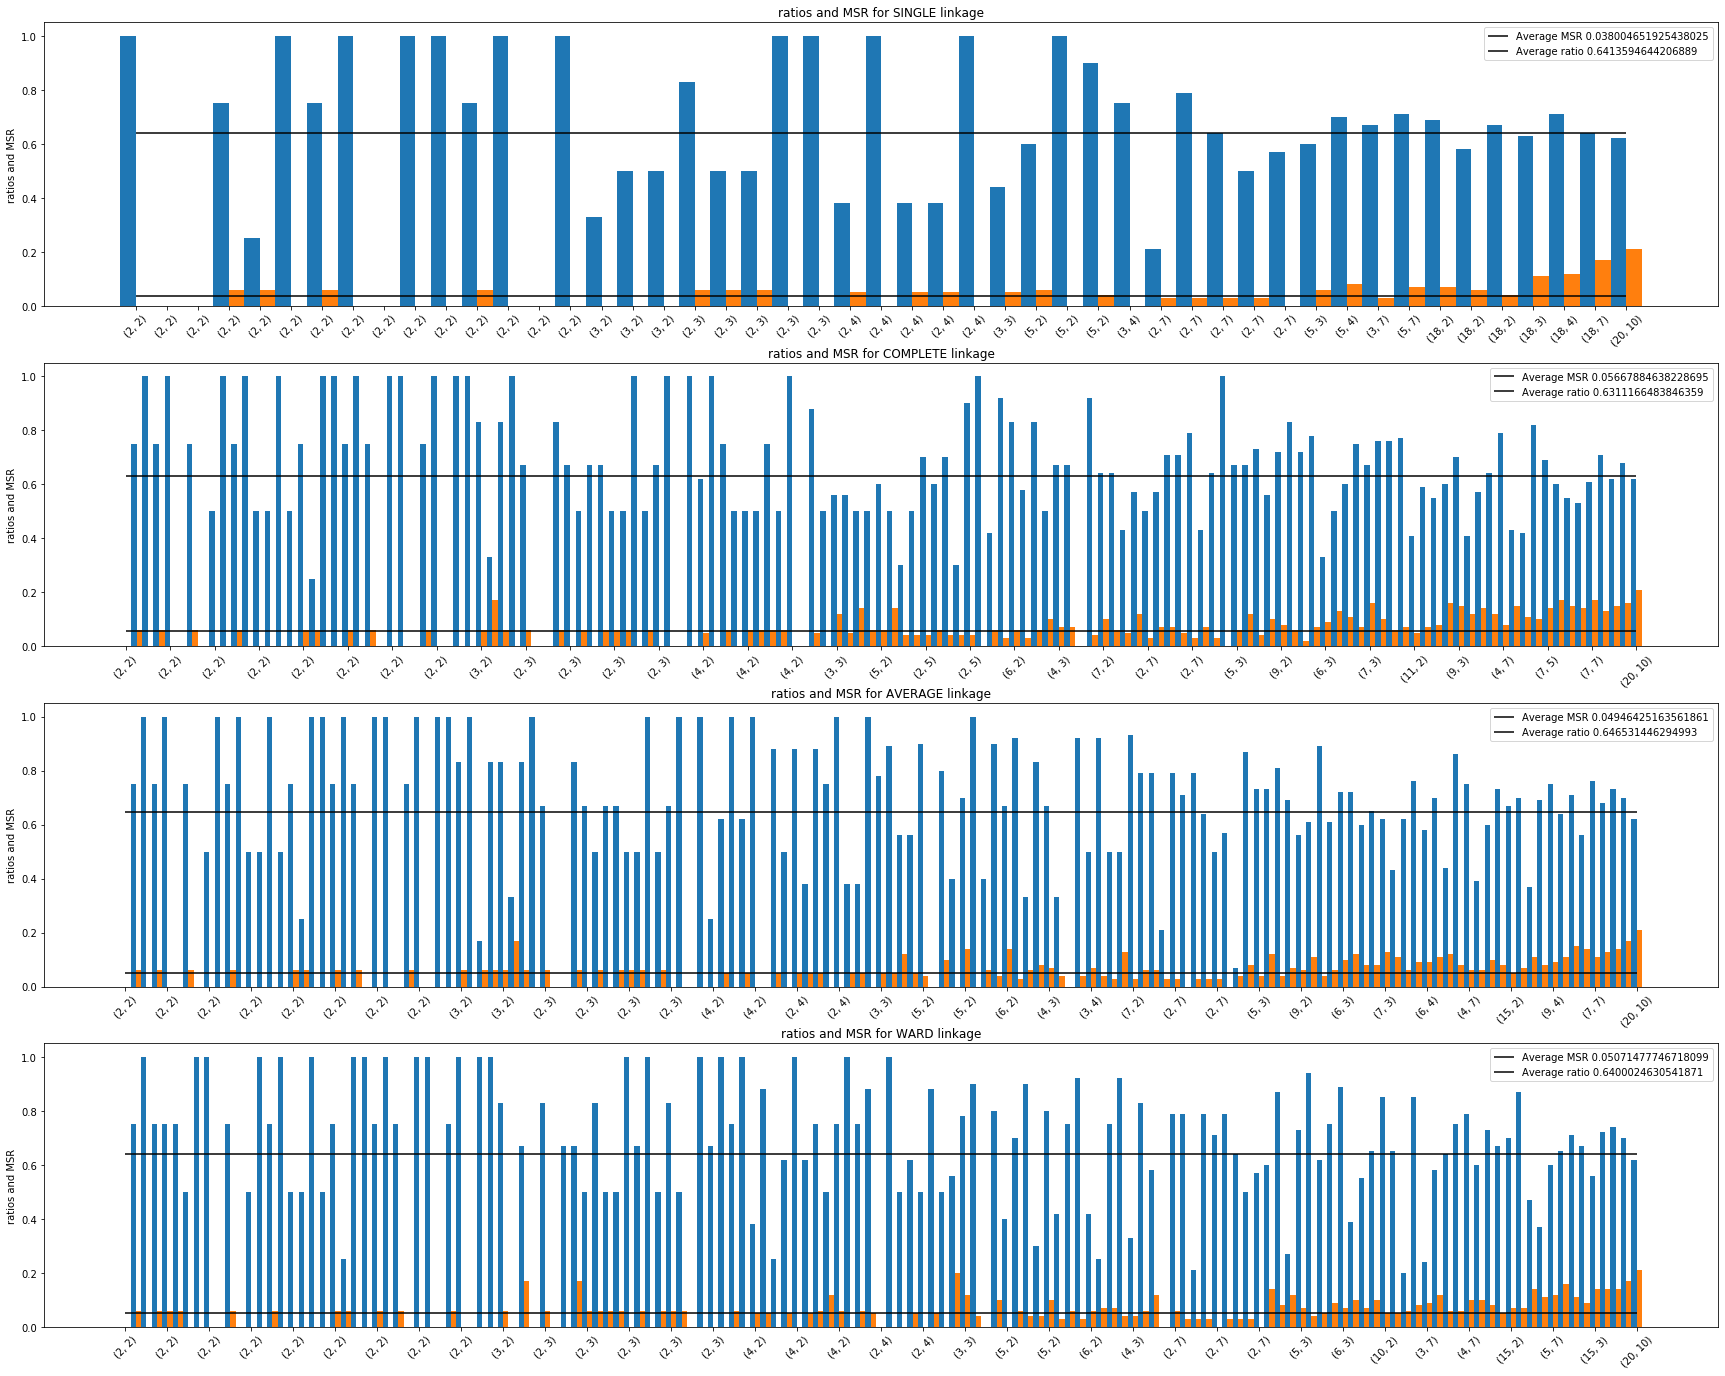

In [6]:
from scipy.cluster.hierarchy import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



class HierBicluster(object):
    '''
    
    '''
    def __init__(self, mat, method, metric):
        mat = mat
        method = method
        metric = metric
        ZR = linkage(mat, method, metric)
        ZC = linkage(np.transpose(mat),method, metric)
       


def getClusters(Z):
#     from heapq import *
    from heapq import heappush, heappop
    j = 0
    clusters = []
    strlist = []
    dis = np.unique(Z[:,2]).tolist()
#     dis.append(1)
    if dis[0] == 0:
        dis = dis[1:]
    for hei in dis:
        cutree = cut_tree(Z, height=hei)
        labels = np.unique(cutree)
        for label in labels:
            temp = np.where(cutree == label)[0]
            strtemp = ','.join(map(str,temp))
            if strtemp in strlist:
                continue
            strlist.append(strtemp)
            if len(temp) > 1:
                heappush(clusters,(len(temp),j,temp,round(hei,2)))
                j += 1
    table = [heappop(clusters) for i in range(len(clusters))][::-1]
    return [(item[0],item[2],item[3]) for item in table ]


def plot_table(axes, df, sub_mat = None, title = 'matrix'):
    axes.set_title(title)
    data = df.values
    axes.axis('off')
    stripe = np.empty(np.array(data).shape, dtype=np.dtype(('U10', 1)) )
    rowColours = []
    colWidths = [0.12 for _ in range(0, stripe.shape[0])]
    for i in range(0,stripe.shape[0]):
        for j in range(0, stripe.shape[1]):

            if i % 2 == 0:
                stripe[i,j] = '0.9'

            else:
                stripe[i,j] = 'w'
    if sub_mat is not None:
        for i in sub_mat[0]:
            for j in sub_mat[1]:
                stripe[i,j] = 'g'

    rowColours = []
    for j in range(0, stripe.shape[0]):
        if j % 2 == 0:    
            rowColours.append('0.9')
        else:
            rowColours.append('1.0')
    stripe
    axes.table(cellText=data,
                          cellColours=stripe,
                          rowColours = rowColours,
                          loc='center',
                          rowLabels=list(df.index),
                          colLabels=list(df.columns),
                          colWidths = colWidths,
                          )

def plot_parallel(ax, df, title = 'Parallel coordinates'):
    

    ax.set_title(title)
    df["index"] = df.index.values
    pd.plotting.parallel_coordinates(
            df, "index", ax=ax,
#             color=('#556270', '#4ECDC4', '#C7F464')
    )

    
def parallelPlot(ax, mat, submat, title):
    rows, cols = submat[0], submat[1]
    df = pd.DataFrame(mat[rows][:,cols],
                      index=rows,columns=cols)
    plot_parallel(ax,df,title=title)



def hClustering(mat,method, metric):
    ZR = linkage(mat,method, metric)
    ZC = linkage(np.transpose(mat),method, metric)
    clusR = getClusters(ZR)
    clusC = getClusters(ZC)
    import pprint
    pp = pprint.PrettyPrinter(indent=1)
    
    print(f'\nClusC of {method}:')
    pp.pprint(clusC)
    print(f'\nClusR of {method}:')
    pp.pprint(clusR)

    return clusR, clusC



 
def biclus(clusR, clusC):
    from heapq import heappush, heappop
    bis = []
    i = 0
    for cr in clusR:
        for cc in clusC:
            dims = cr[0]*cc[0]
            heappush(bis, (dims, i, (cr[1],cc[1]),( cr[0],cc[0]) ))
            i += 1
            
    return [heappop(bis) for i in range(len(bis))]

def MSR(a): 
    return (np.power(a - a.mean(axis=1, keepdims=True) -
                                 a.mean(axis=0) + a.mean(), 2).mean())


def ratioMSR(mat,clusR, clusC):
    bis = biclus(clusR,clusC)
    rows = np.arange(mat.shape[0])
    cols = np.arange(mat.shape[1])
    i = 0
    rmsr = []
    subs = []
    
    ave = [0.0,0.0]
    for bi in bis:
        
        submat = mat[bi[2][0]][:,bi[2][1]]
        subs.append(submat)
        count = np.count_nonzero(submat==0)
        ratio = 1- float(count) / float(submat.size)
        msr = MSR(submat)
        ave[0] += msr
        ave[1] += ratio
#         subs.append(bi[2])       
        rmsr.append((bi[3],round(ratio, 2), round(msr,2), i))
        i += 1
        
    
    count = np.count_nonzero(mat==0)
    ratio = 1- float(count) / float(mat.size)
    msr = MSR(mat)
    ave[0] += msr
    ave[1] += ratio
    i += 1
    
    rmsr.append((mat.shape,round(ratio, 2), round(msr,2),i))
#     subs.append((rows,cols))
    subs.append(mat)
        
    return np.array(rmsr), (ave[0]/i,ave[1]/i), subs


def plot_rmsr(ax,rmsr,ave, method):
    labels = rmsr[:,0]
    x = np.arange(len(rmsr))  # the label locations
    width = 0.5  # the width of the bars
    ax.bar(x - width/2, rmsr[:,1], width)
    ax.bar(x + width/2, rmsr[:,2], width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'ratios and MSR')
    ax.set_title(f'ratios and MSR for {str.upper(method)} linkage')
    
    h1 = ax.hlines(ave[0], x[0],x[-1],label=f'Average MSR {ave[0]}')
    h2 = ax.hlines(ave[1], x[0],x[-1],label=f'Average ratio {ave[1]}')
    
    if method == 'single':
        ax.set_xticks(x)
        ax.set_xticklabels(labels,rotation = 45)
    else:

        labels = [labels[i] for i in range(0,len(labels),4)]
        x = [x[i] for i in range(0,len(x),4)]
        ax.set_xticks(x)
        ax.set_xticklabels(labels,rotation = 45)
    ax.legend(handles=[h1,h2])



    



 




methods = {'single':'hamming',
           'complete':'hamming',
           'average':'hamming',
           'ward':'euclidean' }



size = (20,10)
mat = np.random.choice([1,0],size)

figsize = (size[0]*1.5,6*len(methods))
fig, axes = plt.subplots(nrows=len(methods),figsize=figsize,constrained_layout=False)

i = 0
for method, metric in methods.items():
    clusR, clusC = hClustering(mat,method,metric)
    rmsr, ave, subs = ratioMSR(mat,clusR, clusC)
    plot_rmsr(axes[i],rmsr, ave, method)
    i += 1
    
    




fig.savefig(f'imagesMR/ratioMSR_4.pdf')
plt.show()  
